## Dill 파일을 받았을 때, prediction 하는 역할 수행

In [1]:
import os, dill
import json
from scipy import stats
import matplotlib.pyplot as plt
import sys
import glob
import numpy as np
import torch
import torch.nn as nn
import math

sys.path.append('/home/jovyan/shared-dir/AIMS_recommender_for_paper_submission/')
sys.path.append('/home/jovyan/shared-dir/AIMS_recommender/')

import src.graph_models.graph_util as util
from src.graph_models.gcnn.gin_utils import graph_to_s2vgraphs

torch.set_num_threads(2)
torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DILL_PATH = '/home/jovyan/shared-dir/AIMS_gnn_outputs/base_model_April-17th'
MODEL_PATH = '/home/jovyan/shared-dir/AIMS_gnn_outputs/performance/gcnn_merged_eigs_sorted_model_128'
PERFORMANCE_PATH = '/home/jovyan/shared-dir/AIMS_gnn_outputs/performance'
OUTPUT_NAME = 'April_17_result'

## Base model plot 

In [2]:
def transform_to_s2graph(base_model, performance, feature_dim ):
    graph_info = [base_model]
    graph_info_graphs = [x[0] for x in graph_info]
    graph_info_params = [x[1] for x in graph_info]
    graph_info_model_nm = [x[2] for x in graph_info]
    for (G, p) in zip(graph_info_graphs, graph_info_params):
        G.graph['feat_dim'] = feature_dim
        param_keys = p.keys()
        for u in util.node_iter(G):
            label = util.node_dict(G)[u]['label']
            if label in param_keys:
                feature = p[label]
                if feature.shape[0] != feature_dim:
                    assert feature.shape[0] == feature_dim
            else:
                feature = torch.zeros(feature_dim).squeeze()
            util.node_dict(G)[u]['feat'] = feature.float() 
    test_accuracies = [performance[nm][task_to_metric[task]] for nm in graph_info_model_nm if nm in performance.keys()]
    test_graphs = graph_to_s2vgraphs(graph_info_graphs, test_accuracies, graph_info_model_nm)
    return test_graphs

def load_base_model_result(task, performance, prefix = 'base_'):
    model_path = f'{MODEL_PATH}/model_{OUTPUT_NAME}_{task}.pth'
    print(model_path)
    
    model = torch.load(model_path, map_location=device)
    model.device=device
    
    list_of_models = glob.glob("/home/jovyan/shared-dir/AIMS_gnn_outputs/base_model_April-17th/*")
    feature_dim = 128
    result = {'total_result' : []}
    for idx, model_path in enumerate(list_of_models):
        
        model_type =  model_path.split('/')[-1]
        if model_type.startswith(prefix) is False:
            continue
        with open(model_path, 'rb') as f:
            base_model_dataset=dill.load(f)
        
        for base_model in base_model_dataset:
            if base_model[2] not in performance.keys():
                continue
            test_graphs = transform_to_s2graph(base_model, performance, feature_dim)
            y_pred = model(test_graphs)
        model_nm = base_model_dataset[0][2]
        true_accuracy = performance[model_nm][task_to_metric[task]] if task!='squad_v2' \
                        else performance[model_nm][task_to_metric[task]]/100
        result['total_result'].append({'true_accuracy': true_accuracy,
                             'pred_accuracy': y_pred.view(-1).detach().cpu().numpy()[0],
                             'model_name': base_model_dataset[0][2]})
    return result, test_graphs

In [3]:
task_to_metric = {
            "mrpc" : "eval_accuracy",  "cola" : "eval_matthews_correlation", 
            "rte" :'eval_accuracy', "sst2" :'eval_accuracy', "stsb" :'eval_pearson',
            "wnli" :'eval_accuracy', "squad_v2": "f1", "mnli": "eval_accuracy", 
            "qnli": "eval_accuracy", "qqp": "eval_accuracy"
}

base_model_list = [
    "albert-base-v2", 
    "albert-large-v2",
    "bert-base-uncased", 
    "bert-large-uncased", 
    "distilbert-base-uncased",
    "distilroberta-base", 
    "electra-base-discriminator",
    "electra-large-discriminator",
    "roberta-base", 
    "roberta-large",
    "xlm-roberta-base", 
    "xlm-roberta-large"
]


colors = [
    'tab:blue',
    'tab:blue',
    'tab:orange',
    'tab:orange',
    'tab:purple',
    'tab:purple',
    'tab:pink',
    'tab:pink',
    'tab:olive',
    'tab:olive',
    'tab:cyan',
    'tab:cyan'
]

markers_1 = [
    '.',
    'x',
    '.',
    'x',
    '.',
    'x',
    '.',
    'x',
    '.',
    'x',
    '.',
    'x'
]

markers_2 = [
    'o',
    '^',
    'd',
    '+',
    'x',
    'o',
    '^',
    'd',
    '+',
    'x'
]

# Task for title
task_title = {
    "cola":'CoLA', 
    "mrpc":'MRPC',
    "rte" :'RTE', 
    "sst2" :'SST2', 
    "stsb" :'STSB',
    "wnli" :'WNLI', 
    "squad_v2": 'SQuADv2',
    "mnli": 'MNLI', 
    "qnli": 'QNLI', 
    "qqp": 'QQP'
}

/home/jovyan/shared-dir/AIMS_gnn_outputs/performance/gcnn_merged_eigs_sorted_model_128/model_April_17_result_cola.pth
/home/jovyan/shared-dir/AIMS_gnn_outputs/performance/gcnn_merged_eigs_sorted_model_128/model_April_17_result_mnli.pth
/home/jovyan/shared-dir/AIMS_gnn_outputs/performance/gcnn_merged_eigs_sorted_model_128/model_April_17_result_mrpc.pth
/home/jovyan/shared-dir/AIMS_gnn_outputs/performance/gcnn_merged_eigs_sorted_model_128/model_April_17_result_qnli.pth
/home/jovyan/shared-dir/AIMS_gnn_outputs/performance/gcnn_merged_eigs_sorted_model_128/model_April_17_result_qqp.pth
/home/jovyan/shared-dir/AIMS_gnn_outputs/performance/gcnn_merged_eigs_sorted_model_128/model_April_17_result_rte.pth
/home/jovyan/shared-dir/AIMS_gnn_outputs/performance/gcnn_merged_eigs_sorted_model_128/model_April_17_result_sst2.pth
/home/jovyan/shared-dir/AIMS_gnn_outputs/performance/gcnn_merged_eigs_sorted_model_128/model_April_17_result_stsb.pth


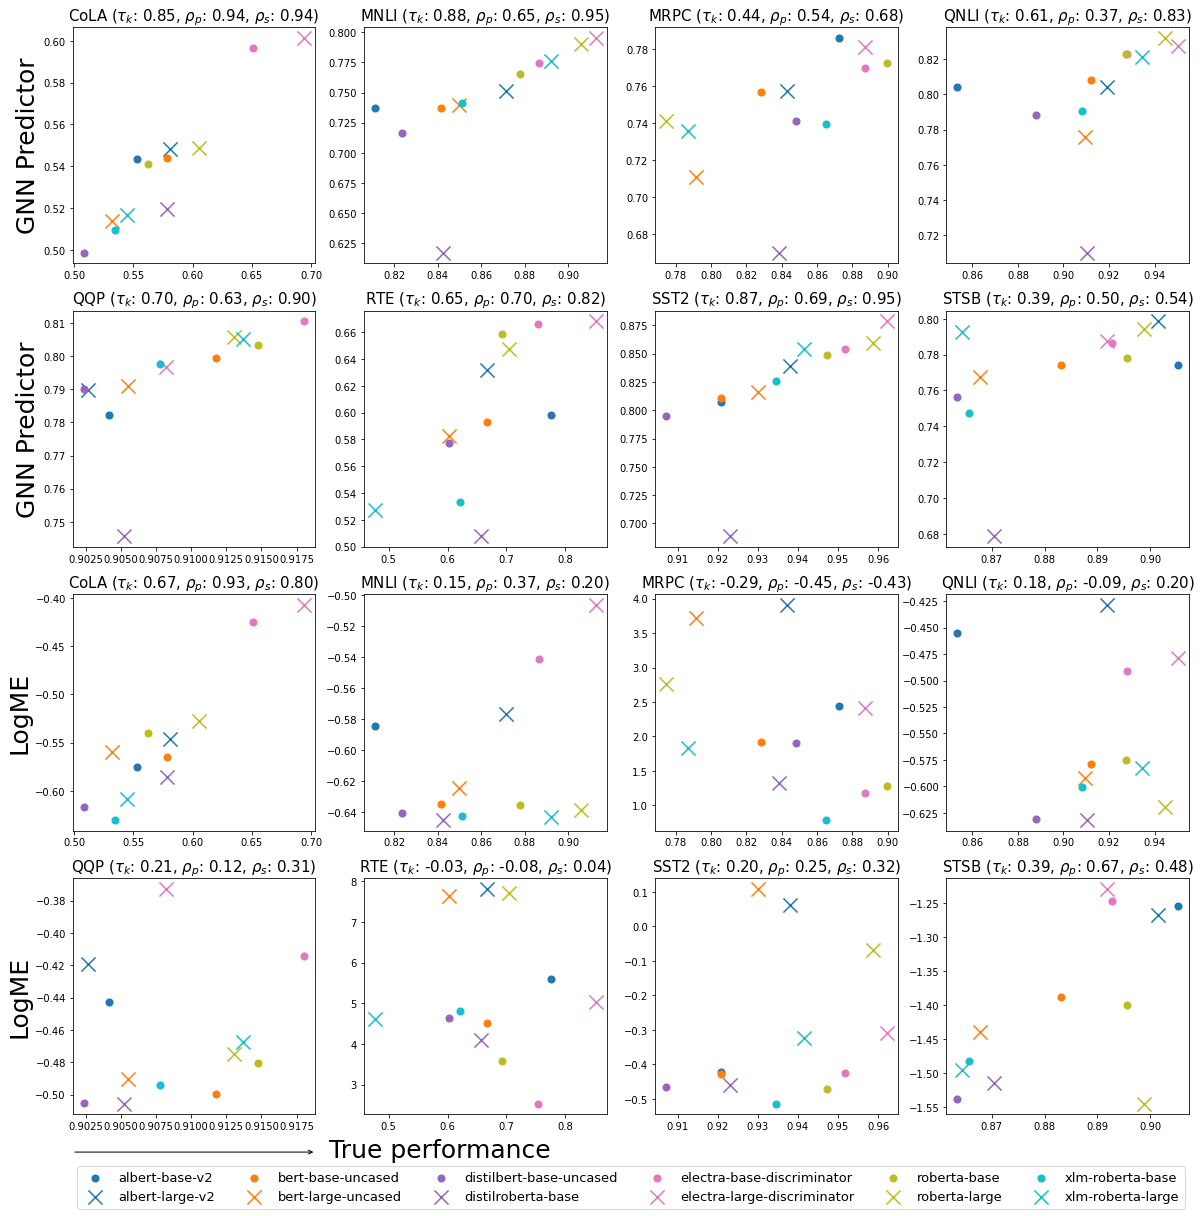

In [4]:
# tasks = ['cola', 'qnli', 'mnli', 'stsb', 'rte', 'mrpc', 'sst2', 'qqp', 'squad_v2']
tasks = [ "cola", "mnli", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb"]

fig = plt.figure(figsize=(20,20))

num_col = 4
num_row = math.ceil(len(tasks) / num_col)

for tdx, task in enumerate(tasks):
    
    with  open( f'{PERFORMANCE_PATH}/base_{task}_performance_score.json', 'r') as f:
        performance = json.load(f)
        performance = performance[task]
    if task != 'squad_v2':
        with  open( f'{PERFORMANCE_PATH}/base_{task}_logme.json', 'r') as f:
            logme = json.load(f)
    model_result, test_graph = load_base_model_result(task, performance)
    perfs = []
    gnn_preds = []
    logme_scores =[]
    
    
    

    for idx, base_model in enumerate(list(performance.keys())):
        gnn_pred_list = [ x['pred_accuracy'] for x in model_result['total_result'] if base_model == x['model_name'] ]
        perf_list = [ x['true_accuracy'] for x in model_result['total_result'] if base_model == x['model_name'] ]
        
        perfs += perf_list
        gnn_preds += gnn_pred_list
        
        plt.subplot(2*num_row, num_col, tdx+1)
        plt.scatter(perf_list, gnn_pred_list, s=200, marker=markers_1[idx], color=colors[idx], label=base_model)
        if tdx % 4 == 0:
            plt.ylabel('GNN Predictor', fontsize=25)
            
        if idx == len(list(performance.keys()))-1:
                tau, tau_p_value = stats.kendalltau(perfs, gnn_preds)
                pearson_cor, pearson_p_value = stats.pearsonr(torch.Tensor(perfs).numpy(), gnn_preds)
                spearman_cor, spearman_p_value = stats.spearmanr(torch.Tensor(perfs).numpy(), gnn_preds)
                plt.title(task_title[task] + r' ($\tau_k$: ${:.2f}$, $\rho_p$: ${:.2f}$, $\rho_s$: ${:.2f}$)'.format(tau, pearson_cor, spearman_cor), fontsize=15)
         
        # LogME
        if task != 'squad_v2':
            logme_list = [logme[base_model]]
            logme_scores += logme_list
            
            plt.subplot(2*num_row, num_col, tdx+num_row*num_col+1)
            plt.scatter(perf_list, logme_list, s=200, marker=markers_1[idx], color=colors[idx], label=base_model)
            if tdx % 4 == 0:
                plt.ylabel('LogME', fontsize=25)
                
            if idx == len(base_model_list)-1:
                tau, tau_p_value = stats.kendalltau(torch.Tensor(perfs).numpy(), logme_scores)
                pearson_cor, pearson_p_value = stats.pearsonr(torch.Tensor(perfs).numpy(), logme_scores)
                spearman_cor, spearman_p_value = stats.spearmanr(torch.Tensor(perfs).numpy(), logme_scores)
                plt.title(task_title[task] + r' ($\tau_k$: {:.2f}, $\rho_p$: {:.2f}, $\rho_s$: {:.2f})'.format(tau, pearson_cor, spearman_cor), fontsize=15)
                
        
    if tdx == len(tasks)-1:
        ax = plt.legend(ncol=6, loc='lower center', bbox_to_anchor=(-1.3, -0.4),borderaxespad=0., fontsize=13)        
   

plt.annotate('', xy=(-3.6, -0.16), xycoords='axes fraction', xytext=(-2.6, -0.16), arrowprops=dict(arrowstyle="<-", color='black'))
fig.text(0.38, 0.095, 'True performance', ha='center', fontsize=25)
# plt.show()
plt.savefig('prediction_9tasks_base.png', dpi=200)

## Unrelated Models?

In [ ]:
# tasks = ['cola', 'qnli', 'mnli', 'stsb', 'rte', 'mrpc', 'sst2', 'qqp', 'squad_v2']
tasks = [ "cola", "mnli", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb"]

interested_models =[ 'bert-base-cased',
                    'bert-large-cased',
                    'bert-base-multilingual-uncased',
                    'bert-base-multilingual-cased',
                    'bert-large-uncased-whole-word-masking',
                    'bert-large-cased-whole-word-masking',
                    'roberta-base-openai-detector',
                    'roberta-large-openai-detector',
                    'distilbert-base-cased',
                    'distilbert-base-multilingual-cased'
                 ]


fig = plt.figure(figsize=(20,20))

num_col = 4
num_row = math.ceil(len(tasks) / num_col)

for tdx, task in enumerate(tasks):
    
    with  open( f'{PERFORMANCE_PATH}/unrelated_base_{task}_performance_score.json', 'r') as f:
        performance = json.load(f)
        performance = performance[task]
    if task != 'squad_v2':
        with  open( f'{PERFORMANCE_PATH}/unrelated_base_{task}_logme.json', 'r') as f:
            logme = json.load(f)
        
    model_result, test_graph = load_base_model_result(task, performance, prefix='unrelated_base_')
    perfs = []
    gnn_preds = []
    logme_scores =[]
    
    for idx, base_model in enumerate(interested_models):
            
        gnn_pred_list = [ x['pred_accuracy'] for x in model_result['total_result'] if base_model == x['model_name'] ]
        perf_list = [ performance[base_model][task_to_metric[task]]  ]
        
        if task == 'squad_v2':
            perf_list = [x/100 for x in perf_list]
        
        perfs += perf_list
        gnn_preds += gnn_pred_list
        
        plt.subplot(2*num_row, num_col, tdx+1)
        plt.scatter(perf_list, gnn_pred_list, s=200, marker=markers_2[idx], label=base_model)
        if tdx % 4 == 0:
                plt.ylabel('GNN Predictor', fontsize=25)
    
        if idx == len(interested_models)-1:
            tau, tau_p_value = stats.kendalltau(perfs, gnn_preds)
            pearson_cor, pearson_p_value = stats.pearsonr(torch.Tensor(perfs).numpy(), gnn_preds)
            spearman_cor, spearman_p_value = stats.spearmanr(torch.Tensor(perfs).numpy(), gnn_preds)
            plt.title(task_title[task] + r' ($\tau_k$: ${:.2f}$, $\rho_p$: ${:.2f}$, $\rho_s$: ${:.2f}$)'.format(tau, pearson_cor, spearman_cor), fontsize=15)
 

        # LogME
        if task != 'squad_v2':
            logme_list = [logme[base_model]]
            logme_scores += logme_list
            
            plt.subplot(2*num_row, num_col, tdx+num_row*num_col+1)
            plt.scatter(perf_list, logme_list, s=200, marker=markers_2[idx], label=base_model)
            if tdx % 4 == 0:
                plt.ylabel('LogME', fontsize=25)
                
            if idx == len(interested_models)-1:
                tau, tau_p_value = stats.kendalltau(torch.Tensor(perfs).numpy(), logme_scores)
                pearson_cor, pearson_p_value = stats.pearsonr(torch.Tensor(perfs).numpy(), logme_scores)
                spearman_cor, spearman_p_value = stats.spearmanr(torch.Tensor(perfs).numpy(), logme_scores)
                plt.title(task_title[task] + r' ($\tau_k$: {:.2f}, $\rho_p$: {:.2f}, $\rho_s$: {:.2f})'.format(tau, pearson_cor, spearman_cor), fontsize=15)
                
        

    if tdx == len(tasks)-1:
        ax = plt.legend(ncol=4, loc='lower center', bbox_to_anchor=(-1.3, -0.5),borderaxespad=0., fontsize=13)        
   
plt.annotate('', xy=(-3.6, -0.16), xycoords='axes fraction', xytext=(-2.6, -0.16), arrowprops=dict(arrowstyle="<-", color='black'))
fig.text(0.38, 0.095, 'True performance', ha='center', fontsize=25)
# plt.show()
plt.savefig('prediction_9tasks_unseen.png', dpi=200)

/home/jovyan/shared-dir/AIMS_gnn_outputs/performance/gcnn_merged_eigs_sorted_model_128/model_April_17_result_cola.pth
/home/jovyan/shared-dir/AIMS_gnn_outputs/performance/gcnn_merged_eigs_sorted_model_128/model_April_17_result_mnli.pth
